In [161]:
from loguru import logger
import pandas as pd
from botwenger.config import PROCESSED_DATA_DIR, PROCESSED_DATA_FILENAME_BETA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker


def loading_features_data(path: str) -> pd.DataFrame:
    logger.info("Loading features data...")
    data = pd.read_csv(path)
    logger.info("Loaded features data")
    return data

In [162]:
data = loading_features_data(f"{PROCESSED_DATA_DIR}/{PROCESSED_DATA_FILENAME_BETA}")

2025-09-12 22:16:28.224 | INFO     | __main__:loading_features_data:11 - Loading features data...
2025-09-12 22:16:28.260 | INFO     | __main__:loading_features_data:13 - Loaded features data


Relationship between price and expected performance (messy scattered plot)

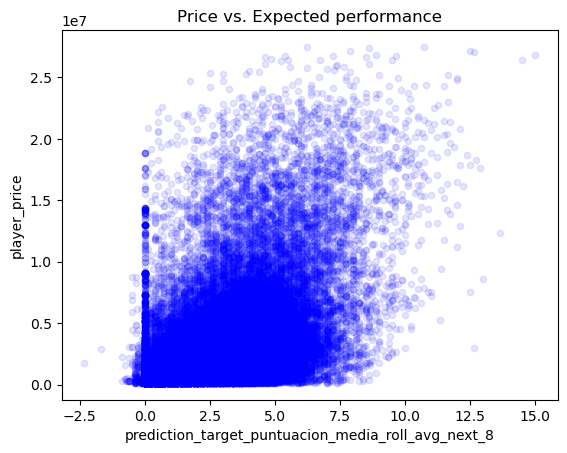

In [163]:
data.plot(kind='scatter', x='prediction_target_puntuacion_media_roll_avg_next_8', y='player_price',alpha=0.1, color='blue', title='Price vs. Expected performance')

plt.show()

In [164]:
def price_performance_plot_lowess(span: str):

    lowess = sm.nonparametric.lowess
    z = lowess(data['player_price'], data['prediction_target_puntuacion_media_roll_avg_next_8'], frac=span)  # frac controls smoothing
    plt.plot(z[:,0], z[:,1], color='red')
    plt.hexbin(data['prediction_target_puntuacion_media_roll_avg_next_8'], data['player_price'], gridsize=50, cmap='viridis', bins='log')
    plt.title('Hexbin with LOWESS Trend')
    plt.show()


Same plot but with Hexbin and LOWESS trend

We can see that even if the data is very noisy, lowering the span enough we can get a smooth LOESS trend that tells us that future points go up with price (as they should), and that the relationship is not exactly linear

/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


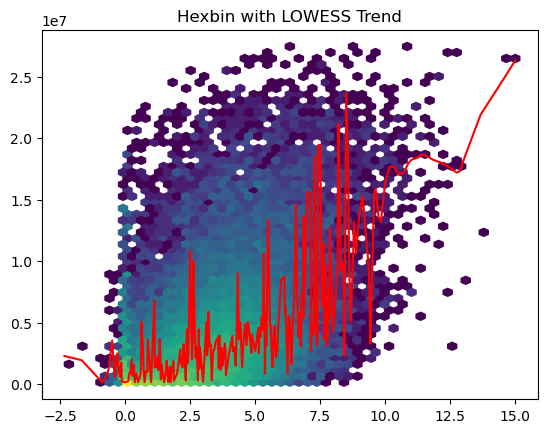

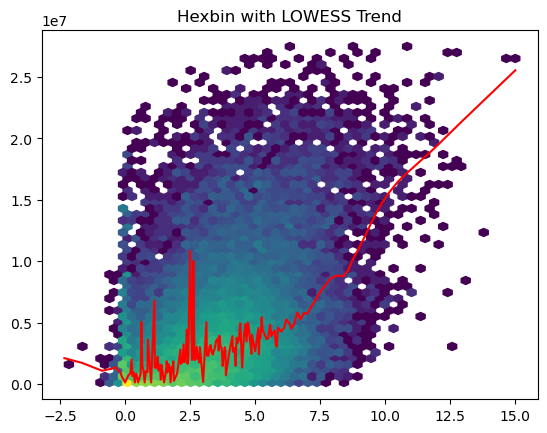

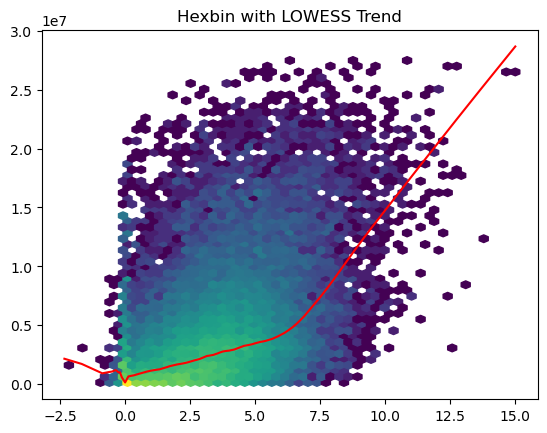

In [165]:
price_performance_plot_lowess(span = 0.001)
price_performance_plot_lowess(span = 0.01)
price_performance_plot_lowess(span = 0.1)

We calculate another LOESS trend, this time comparing price and (price/expected) points ratio, that is, how much money you have to pay per future point. First, to avoid divisions by 0, we replace 0 future points by 0.125 (1 point in 8 matches)

Let's rise the span until it's almost linear: If this function was flat (no slope), where every price range would have the same efficiency (price per point) or the function was purely proportional (no intercept), then it wouldn't matter which price ranges you picked with a fixed amount of money for a fixed (11) amount of players. In the no intercept case, this is because gains in efficiency for "cheap" players are EXACTLY offset by losses in efficiency in "expensive" players for a fixed set of 11 players and X money spent.

In those cases, whatever prices you choose, you would end up with the same expected points sum (in the no intercept case, this is because gains in efficiency for "cheap" players are EXACTLY offset by losses in efficiency in "expensive" players for a fixed set of 11 players and X money spent).

But this is not the case as we can see in the below function, as the LOESS function has both positive slope and positive intercept, and this provokes that any deviation from players with prize = (total_budget/11) will penalize the future points, so it's important to choose players in the right price range to maximize expected points

In [166]:

data.loc[data['prediction_target_puntuacion_media_roll_avg_next_8'] == 0, 'prediction_target_puntuacion_media_roll_avg_next_8'] = 0.125
data["price_points_ratio"] = data["player_price"]/data["prediction_target_puntuacion_media_roll_avg_next_8"]


In [167]:
def price_efficiency_plot_lowess(span: str):

    fig, ax = plt.subplots()

    lowess = sm.nonparametric.lowess
    z = lowess(data['price_points_ratio'], data['player_price'], frac=span)  # frac controls smoothing
    ax.plot(z[:,0], z[:,1], color='red')
    ax.hexbin(data['player_price'], data['price_points_ratio'], gridsize=50, cmap='viridis', bins='log')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2500000))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(600000))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid
    plt.ylim(0, 8000000)
    plt.show()

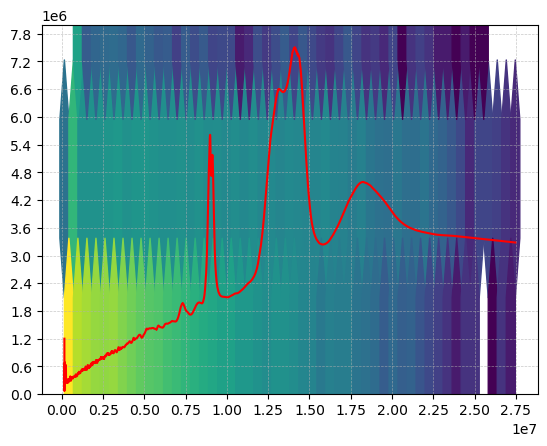

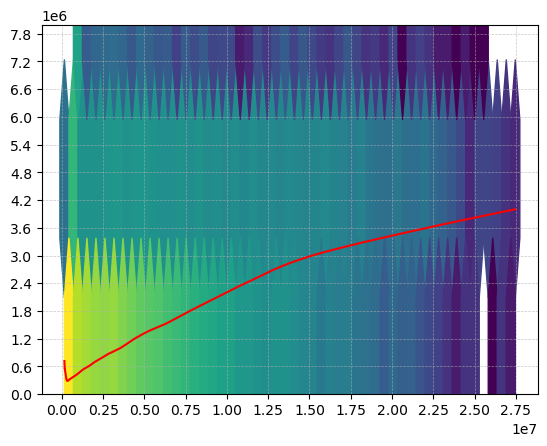

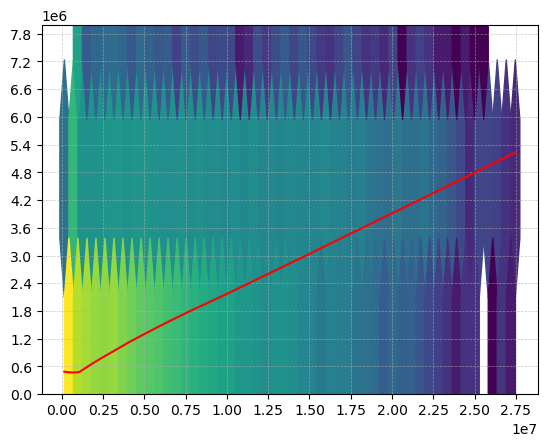

In [193]:
price_efficiency_plot_lowess(span = 0.01)
price_efficiency_plot_lowess(span = 0.1)
price_efficiency_plot_lowess(span = 0.5)

As we saw the data is originally very noisy. Below we compute the rolling average to compare it with the LOESS with span=0.5. We can see the rolling average is consistently higher, this is because of the amount of "0" (we converted to 0.125) future expected points (injuries?), which make the price per future points shoot upwards for the rolling average, but no so much in the LOESS

The rolling average is much more noisier, which is to be expected

In [194]:
import numpy as np

avg_trend_list = []
loess_trend_list = []

lowess = sm.nonparametric.lowess
z = lowess(data['price_points_ratio'], data['player_price'], frac=0.5)  # frac controls smoothing

for x in range(0,16):

    x_target = x*1000000
    y_trend = np.interp(x_target, z[:,0], z[:,1])

    min_price = x_target - 500000
    max_price = x_target + 500000

    avg_income = data.loc[(data['player_price'] >= min_price) & (data['player_price'] <= max_price), 'price_points_ratio'].mean()

    avg_trend_list.append(avg_income)
    loess_trend_list.append(y_trend)

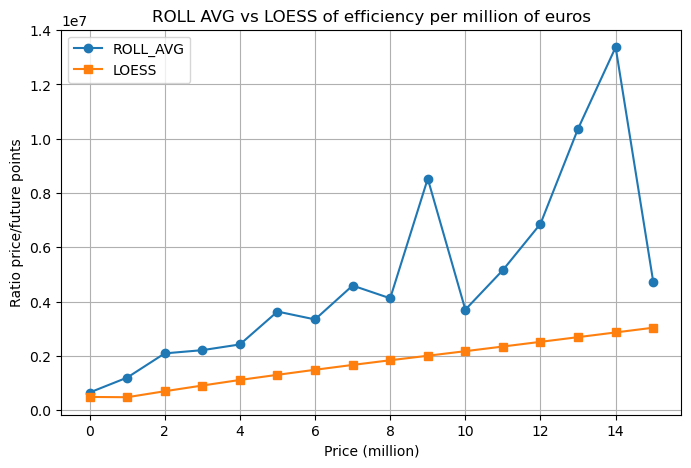

In [195]:
plt.figure(figsize=(8, 5))
m = np.arange(0, 16)
plt.plot(m, avg_trend_list, marker='o', label="ROLL_AVG")
plt.plot(m, loess_trend_list, marker='s', label="LOESS")
plt.title("ROLL AVG vs LOESS of efficiency per million of euros")
plt.xlabel("Price (million)")
plt.ylabel("Ratio price/future points")
plt.legend()
plt.grid(True)
plt.show()

We can use the LOESS function with span = 0.5, as it's smooth and almost linear, to compute optimizations for player picking. The most optimal thing would be to choose 11 players of prize = (total budget/11), but as the model detects inefficiencias in the market (there are lots of variation/noise), we will use this to see when an expensive/cheap player is worth it anyway

The way we'll do it will be: We'll take a player predicted points and price, calculate its efficiency, and with our total budget pretend we are filling the rest of the squad (10 players) with price = (rest of budget/10) and taking the expected efficiency for them from the LOESS regression curve. Then, we'll calculate the expected points sum of this whole squad and compare it with the "optimized" squad (all players with the same price and spending all budget), whose expected efficiencies are also taken from the LOESS curve.

If the points difference is negative, then it's a good player

For players with price close to (total budget/11), just being above average in the expected points will be enough to make the points difference negative. For the rest of the players, they will have to overcome their situation with efficiencies.

(See plot three cells below to undertand how picking one player in different prices with the rest of the squad with the same price and total budget fixed change create a (negative) points difference to the optimized squad where all prices= (total budget/11))

In [225]:
points_difference_list = []
price_list = []

for price in range(150000,10000000,150000):
    
    total_budget = 40000000
    
    #Optimized scenario - all players same price
    price_optimized = total_budget/11
    efficiency_optimized = np.interp(price_optimized, z[:,0], z[:,1])
    
    #Hypotethical buy - player for 10m
    efficiency_bought_player = np.interp(price, z[:,0], z[:,1])

    #Other 10 players
    price_others = (total_budget-price)/10
    efficiency_others = np.interp(price_others, z[:,0], z[:,1])
    
    #Optimized squad future points
    total_points_optimized = (price_optimized/efficiency_optimized)*11
    
    #Hypotethical squad future points
    bought_player_future_points = (price/efficiency_bought_player)
    others_future_points = (price_others/efficiency_others)*10
    total_points_for_split = bought_player_future_points + others_future_points
    
    #Points difference
    points_difference = total_points_optimized - total_points_for_split

    points_difference_list.append(points_difference)
    price_list.append(price)

As we see in the plot below, the optimized route would always be to pick players with price = (budget/11), but individual variations by player will give us lots of chances to pick players in other price ranges with good ratios

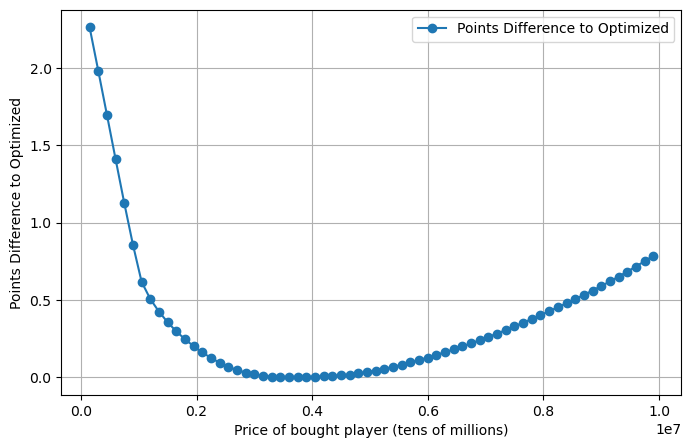

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(price_list, points_difference_list, marker='o', label="Points Difference to Optimized")
plt.ylabel("Points Difference to Optimized")
plt.xlabel("Price of bought player (tens of millions)")
plt.legend()
plt.grid(True)
plt.show()